In [1]:
import as_seg.scripts.default_path as paths
import as_seg.scripts.overall_scripts as scr
import as_seg.data_manipulation as dm
import as_seg.CBM_algorithm as CBM
import as_seg.autosimilarity_computation as as_comp

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl
import matplotlib.pyplot as plt
import itertools


In [2]:
autosimilarity_types = ["Cosine", "Covariance", "RBF"]
bands_numbers = [None, 3, 7, 15]
bands_numbers_labels = ["Full kernel", "3-band kernel", "7-band kernel", "15-band kernel"]
bands_numbers_name_persisted_data = ["full", "3b", "7b", "15b"]

penalty_function = "modulo8"
feature = "log_mel_grill"
subdivision = 96
hop_length = 32
hop_length_seconds = hop_length/44100

lambda_range = np.arange(0.1, 2.1, 0.1)

In [3]:
def load_estimated_segments(song_name, idx_bands_number, autosimilarity_type):
    return np.load(f"../data/RWC Pop/boundary_estimation_WASPAA/rwcpop_{song_name}_{bands_numbers_name_persisted_data[idx_bands_number]}kernel_{autosimilarity_type.lower()}similarity.npy", allow_pickle = True)
    
def compute_experiments_with_precomputed_estimations():
    idx_song_max = 101
    songs_range = range(1,idx_song_max)     
    results_rwc = math.inf * np.ones((len(songs_range), 4, 3, 2, 3)) # Songs, kernels, autosimilarities, tol, metrics
    
    for idx_song, song_name in enumerate(songs_range):
        # Load annotations
        annot_path_mirex = f"../data/RWC Pop/annotations/{dm.get_annotation_name_from_song(song_name, 'MIREX10')}"
        annotations = dm.get_segmentation_from_txt(annot_path_mirex, "MIREX10")
        references_segments = np.array(annotations)[:,0:2]
                
        for idx_bn, bands_number in enumerate(bands_numbers):
            for idx_as, as_type in enumerate(autosimilarity_types):    
                segments_in_time = load_estimated_segments(song_name, idx_bn, as_type)

                prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 0.5)
                prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 3)
                this_score = [[round(prec05,4),round(rap05,4),round(f_mes05,4)], [round(prec3,4),round(rap3,4),round(f_mes3,4)]]
                results_rwc[idx_song, idx_bn, idx_as] = this_score
  
    avg_results_rwc = np.mean(results_rwc, axis = 0)
    
    dataframe = pd.DataFrame(avg_results_rwc.reshape(12, 6), columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = list(itertools.product(bands_numbers_labels,autosimilarity_types)))
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))
    
    return avg_results_rwc
avg_results_rwc = compute_experiments_with_precomputed_estimations()

,P0.5,R0.5,F0.5,P3,R3,F3
"('Full kernel', 'Cosine')",0.625508,0.333692,0.431221,0.814744,0.433453,0.560705
"('Full kernel', 'Covariance')",0.642572,0.588783,0.608768,0.798550,0.726960,0.754054
"('Full kernel', 'RBF')",0.689388,0.551949,0.606159,0.832781,0.664677,0.731087
"('3-band kernel', 'Cosine')",0.406083,0.660396,0.498012,0.507629,0.834358,0.625323
"('3-band kernel', 'Covariance')",0.466051,0.656412,0.540326,0.592960,0.837994,0.688823
"('3-band kernel', 'RBF')",0.433050,0.732823,0.538972,0.525553,0.894094,0.655669
"('7-band kernel', 'Cosine')",0.608860,0.591762,0.596460,0.754599,0.735602,0.740333
"('7-band kernel', 'Covariance')",0.600613,0.632365,0.611609,0.781607,0.822915,0.796548
"('7-band kernel', 'RBF')",0.643196,0.700076,0.665192,0.783050,0.856373,0.811620
"('15-band kernel', 'Cosine')",0.617754,0.410851,0.489675,0.791559,0.528389,0.628873


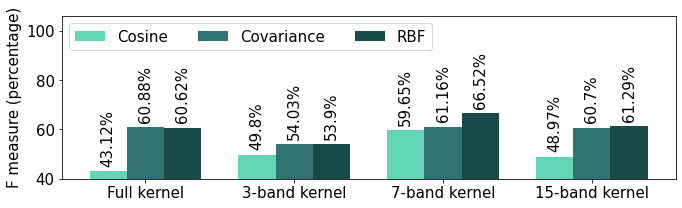

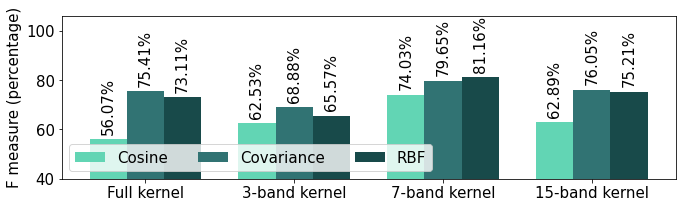

In [4]:
def plot_kernels_as(results_diff_as, kernels_or_features, autosimilarities, tol, title = None):
    # Order results_diff_as: kernels ou features, as, tol
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 15})
    
    width=0.25
    gap = (len(autosimilarities) + 1)*width
    colors = ["#62d5b4", "#317373", "#184a4a", "skyblue"]#['skyblue', 'steelblue', 'darkorange', 'brown']
    
    fig, ax = plt.subplots(1, 1, figsize=(11,3))
    ax.set_ylim( 40, 106 )
    tab = []
    current_start = 0
    for i in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels_or_features))]
        tab.append(ax.bar(indexes, results_diff_as[:,i,tol], color=colors[i], width=width, align='edge'))
        for idx_x, x in enumerate(indexes):
            height = results_diff_as[idx_x, i, tol] 
            plt.text(x +width/2,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width

    ax.set_xticks([current_start/2 + j*gap for j in range(len(kernels_or_features))])
    ax.set_xticklabels(kernels_or_features)
    if tol == 1:
        ax.legend(labels=subaxis, loc='lower left', ncol = 3)
    else:
        ax.legend(labels=subaxis, loc='upper left', ncol = 3)

    ax.set_ylabel("F measure (percentage)")

    #fig.savefig(f"results_barcomp_{tol}.pdf", bbox_inches = "tight")#, format='png')
    if title != None:
        plt.title(title)
    plt.show()

plot_kernels_as(np.round(100 * avg_results_rwc[:,:,:,2], decimals = 2), bands_numbers_labels, autosimilarity_types, 0, title = None)
plot_kernels_as(np.round(100 * avg_results_rwc[:,:,:,2], decimals = 2), bands_numbers_labels, autosimilarity_types, 1, title = None)